In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%pwd

'/home/bene/projects/generative-models/examples/torch_autoencoder'

In [3]:
%cd ../..
%pwd

/home/bene/projects/generative-models


'/home/bene/projects/generative-models'

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms

import pytorch_lightning as pl

import numpy as np

from gempy.torch.encoder import ConvEncoder as Encoder
from gempy.torch.decoder import ConvTDecoder as Decoder
from gempy.torch.variational_auto_encoder import VariationalAutoEncoder

import matplotlib.pyplot as plt

In [5]:
%ls examples/dataset/11KHANDS

hand/


In [6]:
def get_HANDS(batch_size=32, dataset_directory='examples/dataset/11KHANDS', 
              dataloader_workers=1, test_size = 0.1, resolution=64):

    transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                               ])
    dataset = torchvision.datasets.ImageFolder(dataset_directory, transform=transform)
    img = dataset[0][0]
    downscale_y = resolution
    downscale_x = int(img.shape[-1]/img.shape[-2]*downscale_y)
    resize = (downscale_y, downscale_x)

    transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                torchvision.transforms.Resize(resize,)                                                
                                               ])
    dataset = torchvision.datasets.ImageFolder(dataset_directory, transform=transform)

    train_size = int(len(dataset)*(1.-test_size))
    test_size = len(dataset) - train_size

    train_dataset, test_dataset = torch.utils.data.random_split(dataset, 
                                                                [train_size, test_size])

    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=batch_size,
                                               num_workers=dataloader_workers,
                                               pin_memory=True,
                                               shuffle=True)

    test_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                              batch_size=batch_size,
                                              num_workers=dataloader_workers,
                                              pin_memory=True,
                                              shuffle=False)
    
    return train_dataset, test_dataset, train_loader, test_loader

In [7]:
LATENT_DIM = 100

ENCODER_DROPOUT = 0.1
DECODER_DROPOUT = 0.1
USE_BATCHNORM = True

BATCHSIZE = 64
LEARNINGRATE = 0.0005
EPOCHS = 200
MODEL_PATH = 'examples/models/vae/torch/'

train_dataset, test_dataset, train_loader, test_loader = get_HANDS(
    batch_size=BATCHSIZE, dataloader_workers=12, test_size=0.1
)

min: tensor(0.0332)
max: tensor(1.)
input shape: (3, 64, 85)


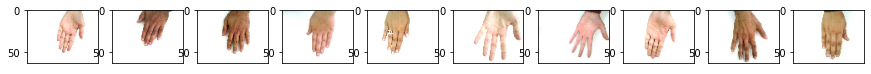

In [8]:
f, axes = plt.subplots(1, 10, figsize=(15, 5))
for ax in axes:
    tensor = train_dataset[np.random.randint(len(train_dataset))][0]
    ax.imshow(tensor.detach().numpy().transpose(1,2,0), cmap='binary')
    ax.set_xticks([]); ax.set_yticks

print('min:', train_dataset[0][0].min())
print('max:', train_dataset[0][0].max())
    
input_shape = tuple(train_dataset[0][0].shape)
print('input shape:', input_shape)

In [9]:
z_dim = (LATENT_DIM, LATENT_DIM)
z_labels = ('mu', 'log_var')

In [10]:
device = 'cpu'
if torch.cuda.is_available():
    print (f'GPU available')
    device = 'cuda'

x_random = torch.rand((1, *input_shape))

GPU available


In [11]:
encoder = Encoder(
    input_shape=input_shape,
    filters=(32, 64, 64, 128),
    kernels_size=(3, 3, 3, 3),
    strides=(1, 2, 2, 1),
    activation='relu',
    latent_dim=z_dim,
    latent_labels=z_labels,
    latent_activation='sin',
    use_dropout=ENCODER_DROPOUT,
    use_batch_norm=USE_BATCHNORM
)

print('Encoder:')
for l in encoder.conv_stack:
    print('- label:', l[0], '\tshape:', l[-1], '\tactivation:', l[-2])
for l in encoder.latent_stack:
    print('- label:', l[0], '\tshape:', l[-1], '\tactivation:', l[-2])    

Encoder:
- label: conv_0 	shape: (32, 64, 85) 	activation: None
- label: batch_norm_0 	shape: (32, 64, 85) 	activation: <built-in method relu of type object at 0x7f932d2bcca0>
- label: drop_0 	shape: (32, 64, 85) 	activation: None
- label: conv_1 	shape: (64, 32, 43) 	activation: None
- label: batch_norm_1 	shape: (64, 32, 43) 	activation: <built-in method relu of type object at 0x7f932d2bcca0>
- label: drop_1 	shape: (64, 32, 43) 	activation: None
- label: conv_2 	shape: (64, 16, 22) 	activation: None
- label: batch_norm_2 	shape: (64, 16, 22) 	activation: <built-in method relu of type object at 0x7f932d2bcca0>
- label: drop_2 	shape: (64, 16, 22) 	activation: None
- label: conv_3 	shape: (128, 16, 22) 	activation: None
- label: batch_norm_3 	shape: (128, 16, 22) 	activation: <built-in method relu of type object at 0x7f932d2bcca0>
- label: drop_3 	shape: (128, 16, 22) 	activation: None
- label: latent_mu 	shape: 100 	activation: <built-in method sin of type object at 0x7f932d2bcca0>
-

In [12]:
decoder = Decoder(
    latent_dim=z_dim[0],
    latent_upscale=encoder.conv_stack_shape_out,
    filters=[128, 64, 32, 3],
    kernels_size=[3, (4, 3), (4, 3), 3],
    strides=[1, 2, 2, 1],
    activation=['leaky_relu', 'leaky_relu', 'leaky_relu', 'sigmoid'],
    latent_merge=True,
    latent_activation=None,
    use_dropout=DECODER_DROPOUT,
    use_batch_norm=USE_BATCHNORM
)

print('Decoder:')
for l in decoder.latent_stack:
    print('- label:', l[0], '\tshape:', l[-1], '\tactivation:', l[-2])
for l in decoder.deconv_stack:
    print('- label:', l[0], '\tshape:', l[-1], '\tactivation:', l[-2])

Decoder:
- label: decode_latent_0 	shape: (128, 16, 22) 	activation: None
- label: deconv_0 	shape: (128, 16, 22) 	activation: None
- label: debatch_norm_0 	shape: (128, 16, 22) 	activation: <function leaky_relu at 0x7f92a70dde50>
- label: dedrop_0 	shape: (128, 16, 22) 	activation: None
- label: deconv_1 	shape: (64, 32, 43) 	activation: None
- label: debatch_norm_1 	shape: (64, 32, 43) 	activation: <function leaky_relu at 0x7f92a70dde50>
- label: dedrop_1 	shape: (64, 32, 43) 	activation: None
- label: deconv_2 	shape: (32, 64, 85) 	activation: None
- label: debatch_norm_2 	shape: (32, 64, 85) 	activation: <function leaky_relu at 0x7f92a70dde50>
- label: dedrop_2 	shape: (32, 64, 85) 	activation: None
- label: deconv_3 	shape: (3, 64, 85) 	activation: <built-in method sigmoid of type object at 0x7f932d2bcca0>


In [13]:
model = VariationalAutoEncoder(
    encoder=encoder,
    decoder=decoder,
    #beta=0.1, reconstruction_loss='gaussian_likelihood'
    beta=1e4, 
    reconstruction_loss='mse_reconstruction_loss', 
    learning_rate=LEARNINGRATE,
    batch_size=BATCHSIZE,
)

In [14]:
print('input shape     :', model.encoder.conv_stack_shape_in)
print('latent shape     :', model.encoder.conv_stack_shape_out)
print('z shape          :', (z_dim[0],))
print('output shape    :', model.decoder.deconv_stack_shape_out)

input shape     : (3, 64, 85)
latent shape     : (128, 16, 22)
z shape          : (100,)
output shape    : (3, 64, 85)


In [15]:
y = model(x_random)

print('latent space    :', encoder.latent_torch)
print('output shape    :', y.shape)
print('loss            :', model.training_step((x_random,None)))


latent space    : None
output shape    : torch.Size([1, 3, 64, 85])
loss            : tensor(1681.7428, grad_fn=<MeanBackward0>)


In [16]:
# Init ModelCheckpoint callback, monitoring 'val_loss'
checkpoint_callback_loss = pl.callbacks.ModelCheckpoint(monitor='loss', save_top_k=1, mode='min')
checkpoint_callback_val_loss = pl.callbacks.ModelCheckpoint(monitor='val_loss')
checkpoint_callback_r_loss = pl.callbacks.ModelCheckpoint(monitor='r_loss')
checkpoint_callback_kl_loss = pl.callbacks.ModelCheckpoint(monitor='KL_loss')

trainer = pl.Trainer(max_epochs=EPOCHS, 
                     gpus=int('cuda' in device), 
                     default_root_dir=MODEL_PATH,
                     callbacks=[checkpoint_callback_loss,
                                checkpoint_callback_val_loss,
                                checkpoint_callback_r_loss,
                                checkpoint_callback_kl_loss,
                               ],
                     precision=16,                         # accelerate 
                     auto_scale_batch_size='binsearch',  # run batch size scaling, result overrides hparams.batch_size
                     auto_lr_find=True,                  # run learning rate finder, results override hparams.learning_rate
                     check_val_every_n_epoch=1,
                    )

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.


In [17]:
model.set_train_dataloader(train_loader)
model.set_val_dataloader(test_loader)

trainer.tune(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Batch size 2 succeeded, trying batch size 4
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Batch size 4 succeeded, trying batch size 8
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Batch size 8 succeeded, trying batch size 16
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Batch size 16 succeeded, trying batch size 32
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Batch size 32 succeeded, trying batch size 64
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Batch size 64 succeeded, trying batch size 128
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Batch size 128 succeeded, trying batch size 256
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Batch size 256 succeeded, trying batch size 512
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Batch size 512 succeeded, trying batch size 1024
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Batch size 1024 succeeded, trying batch size 2048
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Batch size 2048 succeeded, trying batch size 4096
LOCAL_RANK: 0 - CUDA_

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/home/bene/anaconda3/envs/gempy/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/home/bene/anaconda3/envs/gempy/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: You're resuming from a checkpoint that ended mid-epoch. Training will start from the beginning of the next epoch. This can cause unreliable results if further training is done, consider using an end of epoch checkpoint.
  warnings.warn(*args, **kwargs)
Restored states from the checkpoint file at examples/models

{'scale_batch_size': 9968,
 'lr_find': <pytorch_lightning.tuner.lr_finder._LRFinder at 0x7f92a0fcaee0>}

In [ ]:
trainer.fit(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type         | Params
-----------------------------------------
0 | encoder | ConvEncoder  | 9.1 M 
1 | decoder | ConvTDecoder | 4.8 M 
-----------------------------------------
14.0 M    Trainable params
1         Non-trainable params
14.0 M    Total params
55.859    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 98it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [ ]:
# new_model = MyModel.load_from_checkpoint(checkpoint_path="example.ckpt")

In [ ]:
for batch_features, __ in test_loader:
    out = model.forward(batch_features)
    
    f, axes = plt.subplots(1, 5, figsize=(15, 5))
    for i, ax in enumerate(axes):
        ax.imshow(batch_features[i+10].detach().numpy().transpose(1,2,0), cmap='binary')
        ax.set_xticks([]); ax.set_yticks
     
    f, axes = plt.subplots(1, 5, figsize=(15, 5))
    for i, ax in enumerate(axes):
        ax.imshow(out[i+10].detach().numpy().transpose(1,2,0), cmap='binary')
        ax.set_xticks([]); ax.set_yticks
        
    break

In [ ]:
help(trainer)